In [ ]:
pip install xgboost yfinance pandas numpy scikit-learn matplotlib

In [3]:
print("Hello, World!")

Hello, World!


In [5]:
import xgboost
import yfinance
import pandas as pd
import numpy as np
import sklearn
import matplotlib

print(xgboost.__version__, yfinance.__version__, pd.__version__, np.__version__, sklearn.__version__, matplotlib.__version__)

3.1.2 0.2.66 2.2.3 2.1.2 1.7.1 3.9.2


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6404\3860962857.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('HDFCBANK.NS', start='2022-04-01', end=datetime.now().strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open      Volume
Ticker     HDFCBANK.NS HDFCBANK.NS HDFCBANK.NS HDFCBANK.NS HDFCBANK.NS
Date                                                                  
2022-04-01  716.310120  718.212670  699.329883  702.231260    14568556
2022-04-04  788.036316  819.095413  743.207477  751.507329    97450970
2022-04-05  764.943970  792.744957  761.971236  792.744957    30922582
2022-04-06  737.642395  756.168510  735.977664  755.169625    27027860
2022-04-07  721.423218  733.123889  719.972500  733.100142    40781732
Dataset shape: (901, 5)
Mean Squared Error on Validation: 81.59


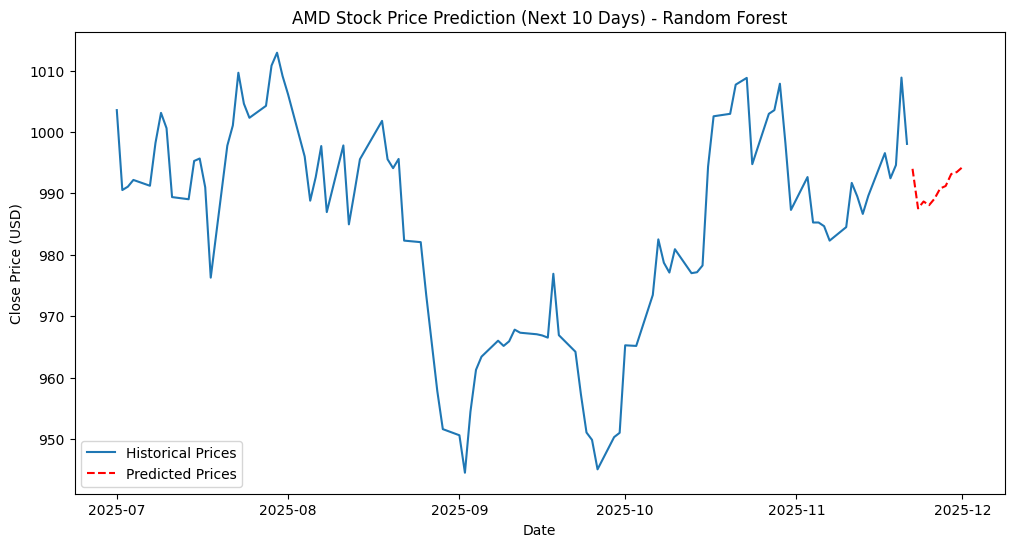

In [11]:
# Stock Price Prediction using Random Forest (Safe Version)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error

# Step 1: Fetch AMD stock data
df = yf.download('HDFCBANK.NS', start='2022-04-01', end=datetime.now().strftime('%Y-%m-%d'))

if df.empty:
    raise ValueError("No stock data fetched. Check ticker or internet connection.")

print(df.head())
print("Dataset shape:", df.shape)

# Step 2: Prepare Close prices
if 'Close' not in df.columns:
    raise ValueError("Downloaded data has no 'Close' column!")

data = df[['Close']].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Step 3: Split train/validation
training_data_len = int(len(scaled_data) * 0.95)
train_data = scaled_data[:training_data_len]
valid_data = scaled_data[training_data_len:]

# Function to create dataset
def create_dataset(dataset, time_step=30):  # use 30-day window for safety
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data)
X_valid, y_valid = create_dataset(valid_data)

# Safety check: if validation is empty, fall back to last part of training
if X_valid.size == 0 or y_valid.size == 0:
    print("⚠️ Validation set too small. Using last part of training data instead.")
    split_point = int(len(train_data) * 0.8)
    X_valid, y_valid = create_dataset(train_data[split_point:])

# Step 4: Train Random Forest
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=8,
    random_state=42
)
model.fit(X_train, y_train)

# Step 5: Evaluate
y_pred_scaled = model.predict(X_valid)

y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_valid_actual = scaler.inverse_transform(y_valid.reshape(-1, 1))

mse = mean_squared_error(y_valid_actual, y_pred)
print(f"Mean Squared Error on Validation: {mse:.2f}")

# Step 6: Predict next 10 days
last_30_days = scaled_data[-30:].reshape(1, -1)
future_prices = []

for i in range(10):
    pred_scaled = model.predict(last_30_days)[0]
    future_prices.append(pred_scaled)
    last_30_days = np.append(last_30_days[:, 1:], [[pred_scaled]], axis=1)

future_prices = scaler.inverse_transform(np.array(future_prices).reshape(-1, 1))

# Future dates
last_date = df.index[-1]
future_dates = pd.date_range(last_date + timedelta(days=1), periods=10)

# Step 7: Plot
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100:], df['Close'].tail(100), label='Historical Prices')
plt.plot(future_dates, future_prices, linestyle='dashed', color='red', label='Predicted Prices')
plt.title('AMD Stock Price Prediction (Next 10 Days) - Random Forest')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()